In [1]:
import decoder_bindings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from prettytable import PrettyTable
from IPython.display import display, Markdown
import seaborn as sns
colors = sns.color_palette('colorblind')

plt.style.use('/home/pgrams/latex-cm.mplstyle')

In [2]:
def plot_charge_channels(adc_words, event, num_channel, timesize, charge_range=[1950, 2150]):
    xdown, xup = -int(timesize/2), timesize
    
    plt.figure(figsize=(18,6))
    plt.imshow(adc_words, cmap=plt.cm.RdBu_r, extent=[xdown, xup, 0, num_channel], vmin=charge_range[0], vmax=charge_range[1], origin='lower')
    plt.plot([0, 0], [0, num_channel], linestyle='--', color='gray')
    plt.plot([xup / 2, xup / 2], [0, num_channel], linestyle='--', color='gray')
    clb=plt.colorbar()
    clb.set_label('Charge  [ADC]')
    plt.xticks(np.arange(-150, 300, 50))
    plt.yticks(np.arange(0, num_channel+1, 16))

    plt.title("Event " + str(event))
    plt.xlabel("[$\\mu$s]")
    plt.ylabel("Channel")
    plt.xlim(xdown,xup)
    plt.show()

def plot_difference(evt, channel):
    shift = 4
    approx_baseline = readout_df['light_adc_words'][evt][channel, 0]
    diff = readout_df['light_adc_words'][evt][channel, shift:].astype(float) - readout_df['light_adc_words'][evt][channel, :-shift].astype(float)
    diff[diff < 0] = 0
    plt.plot(np.concatenate((np.ones(shift)*approx_baseline, diff+approx_baseline)), linestyle='--')
    
# def gaussian(x, amplitude, mean, stddev):
#     gauss = amplitude * np.exp(-((x - mean) / (2 * stddev))**2) 
#     return gauss

def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)

def gaussian_exp(x, amplitude, mean, stddev, tau):
    exp = np.exp(-(x - mean) / tau)
    exp[x <= mean] = 0
    gauss = amplitude * (np.exp(-((x - mean) / (2 * stddev))**2)  + exp)
    gauss[x > mean] /= 2
    return gauss 

def fit_histogram(h, cb, frac=0.3):
    # 3. Use scipy.optimize.curve_fit to fit the histogram
    bc = (cb[:-1] + cb[1:]) / 2
    mask = h > frac * np.max(h)
    popt, pcov = curve_fit(gaussian, bc[mask], h[mask], p0=[max(h), 2000, 200])
    # popt, pcov = curve_fit(gaussian_exp, bc[mask], h[mask], p0=[max(h), 2050, 25,1])
    return bc[mask], popt

def plot_trigger_rate(df, fem_num, bin_range, framesize=255, axis=None):
    '''
    Reconstruct trigger rate
    
    Time between trigger is,
    Δs = trig_sample[i] - trig_sample[i-1]
    Δf = trig_frame[i] - trig_frame[i-1]
    framesize = trigger framesize in 2MHz ticks, likely 255 = 128μs for pGRAMS
    ΔT = Δf * framesize + Δs
    '''
    f1 = df['event_frame_number'].str[fem_num][:-1].values.astype(float)
    f2 = df['event_frame_number'].str[fem_num][1:].values.astype(float)
    # f1 = df['trigger_frame_number'].str[fem_num][:-1].values.astype(float)
    # f2 = df['trigger_frame_number'].str[fem_num][1:].values.astype(float)
    
    s1 = df['trigger_sample'].str[fem_num][:-1].values.astype(float)
    s2 = df['trigger_sample'].str[fem_num][1:].values.astype(float)
    
    trig_time_diff = (f2 - f1) * framesize + (s2 - s1)
    trig_time_diff[trig_time_diff == 0] = 1e-10

    if axis is None:
        c,_,_ = plt.hist(1. / (trig_time_diff * 5.e-7), bins=50, range=bin_range)
        plt.xticks(np.arange(bin_range[0],bin_range[1]+1, 50))
        plt.xlabel('Trigger Rate [Hz]  (from event $\\Delta$t)')
    else:
        c,_,_ = axis.hist(1. / (trig_time_diff * 5.e-7), bins=50, range=bin_range, alpha=0.8, density=True)
        axis.set_xticks(np.arange(bin_range[0],bin_range[1]+1, 50))
        axis.set_xlabel('Trigger Rate [Hz]  (from event $\\Delta$t)')
    
    print("Number of events in histogram:", np.sum(c))
    print(c)
    
    # plt.show()
    return 1. / (trig_time_diff * 5.e-7)    

def concat_row_arrays(row):
  return np.concatenate(row)

def get_event_data(files, key_list=None, get_hits_only=False):
    file_list = [files] if type(files) is not list else files
    
    readout_data = []
    evt_cnt = 0
    for fname in file_list:
        proc = decoder_bindings.ProcessEvents(light_slot=16)
        proc.open_file(fname)
        while proc.get_event():
            try:
                tmp = proc.get_event_dict()
                if get_hits_only:
                    if not are_hits(readout_df=tmp, event=None):
                        continue
                if key_list is not None: tmp = {key: tmp[key] for key in key_list}
                readout_data.append(tmp)
                evt_cnt += 1
            except:
                continue
            if evt_cnt == 5000:
                break

        
    # Data frame with 1 event per row
    readout_df = pd.DataFrame(readout_data)
    
    return readout_df, proc

def plot_charge_waveforms(readout_df, event, channel_range, timesize=255, overlay=False, range=[], create_fig=True, show_legend=True):
    
    ch_down = channel_range[0]
    ch_up = channel_range[1]
    
    baseline_subtract = 2000
    fig_height = 18 if (ch_up - ch_down) > 15 else 12
    if ch_down == ch_up or overlay:
        baseline_subtract = 0
        fig_height = 8

    if create_fig: plt.figure(figsize=(18,fig_height))
    for i, qch in enumerate(readout_df['charge_adc_words'][event][ch_down:ch_up+1,:]):
        baseline_shift = i * 2000 if not overlay else 0
        plt.plot(np.linspace(-timesize/2, timesize, len(qch)), qch.astype(int) - baseline_subtract + baseline_shift, label=f'Channel {ch_down+i}')

    xdown, xup = -int(timesize/2), timesize
    plt.xticks(np.arange(-int(timesize/10)*10, int((timesize*2)/10)*10, 50))
    plt.title("Event " + str(event))
    plt.xlabel("[$\\mu$s]")
    plt.ylabel("Charge [ADC]")
    if show_legend: plt.legend(loc='best')
    if ch_down == ch_up or overlay: plt.ylim(range)
    if create_fig: plt.show()

def are_hits(readout_df, event):
    """
    Use for event selection. Check if there are any large-ish charge hits in the event in any of the 32 channels.
    """
    charge_channels = readout_df['charge_adc_words'] if event is None else readout_df['charge_adc_words'][event]
    for i in range(0, 32):
        if len(find_peaks(charge_channels[i,:], height=10, prominence=15)[0]) > 0:
            return True 
    return False

def find_hits(readout_df, event):
    """
    Find the channel and peak of charge hits in an event across 32 channels.
    """
    hit_idx_list = []
    hit_channel_list = []
    for i in range(0, 32):
        idx_arr = find_peaks(readout_df['charge_adc_words'][event][i,:], height=10, prominence=15)[0]
        if len(idx_arr) > 0:
            hit_idx_list.append(idx_arr)
            hit_channel_list.append(i)
    return np.asarray(hit_channel_list), np.asarray(hit_idx_list)

def get_light_trigger_sample(trig_frame, trig_sample, light_frames, light_samples):
    """
    When using the light as a trigger we can find the light sample closest to the trigger sample
    and use that as the trigger sample time. The advantage is the light sample is higher resolution
    at 64MHz while the trigger sample is at 2MHz. 
    !This does not work for an external trigger.
    """
    light_frames[light_frames == trig_frame]
    # Get all the ROIs in the trigger frame
    light_samples_in_trig_frame = light_samples[light_frames == trig_frame]
    #Convert the trigger sample from 2MHz to 64MHz
    trig_sample_64mhz = trig_sample * 32
    # Find the nearest light ROI to the trigger sample, this should be the one which caused the trigger
    nearest_roi_idx = np.argmin(np.abs(trig_sample_64mhz - light_samples_in_trig_frame))
    return light_samples_in_trig_frame[nearest_roi_idx]

def get_full_light_data(readout_df, event, channel):
    """
    Reconstruct the full 4 light frames in an event given the ROIs.
    """
    fem_number = np.arange(len(readout_df["slot_number"][event]))[readout_df["slot_number"][event] == 16]
    min_light_frame = np.min(readout_df['light_frame_number'][event]).astype(float)
    
    light_trigger_sample = get_light_trigger_sample(trig_frame=readout_df['trigger_frame_number'][event][fem_number].astype(float), 
                                                      trig_sample=readout_df['trigger_sample'][event][fem_number].astype(float), 
                                                      light_frames=readout_df['light_frame_number'][event].astype(float), 
                                                      light_samples=readout_df['light_readout_sample'][event].astype(float))
    
    full_waveform = decoder_bindings.get_full_light_waveform(channel, readout_df['light_channel'][event].astype(int), 
                                                             min_light_frame,
                                                             readout_df['light_readout_sample'][event].astype(float), 
                                                             readout_df['light_frame_number'][event].astype(float), 
                                                             readout_df['light_adc_words'][event], 255)
    
    full_axis = decoder_bindings.get_full_light_axis(readout_df['trigger_frame_number'][event][fem_number].astype(float), 
                                                      light_trigger_sample, 
                                                      min_light_frame, 255, True)

    return full_axis, full_waveform

In [3]:
# runs with ribbon cable (9/25/2025):
# file_names = ["/home/pgrams/data/readout_data/pGRAMS_bin_560_0.dat"] # 300mVpp, 200Hz trigger, 5000 evts
# file_names = ["/home/pgrams/data/readout_data/pGRAMS_bin_561_0.dat"] # 300mVpp, 200Hz trigger, 10000 evts
ribbon_file = ["/home/pgrams/data/readout_data/pGRAMS_bin_562_0.dat", "/home/pgrams/data/readout_data/pGRAMS_bin_562_1.dat"] # 800mVpp, 200Hz trigger, 10000 evts
# file_names = ["/home/pgrams/data/readout_data/pGRAMS_bin_563_0.dat", "/home/pgrams/data/readout_data/pGRAMS_bin_563_1.dat"] # 1.1Vpp, 200Hz trigger, 43000 evts

# run with shielded cable (9/25/2025):
shield_file = ["/home/pgrams/data/readout_data/pGRAMS_bin_565_0.dat"] # 800mVpp, 200Hz trigger, 10000 evts
            
process = decoder_bindings.ProcessEvents(light_slot=16, use_charge_roi=False, channel_threshold=[])
process.open_file(ribbon_file[0])

ribbon_data = []
while process.get_event():
    try:
        tmp_dict = process.get_event_dict()
        ribbon_data.append(tmp_dict)
        event_num += 1
    except:
        continue

ribbon_df = pd.DataFrame(ribbon_data)

Opening file /home/pgrams/data/readout_data/pGRAMS_bin_562_0.dat
File size: 489508308
Allocated file buffer..
Read file..
+++ Event [0]
+++ Event [500]
+++ Event [1000]
+++ Event [1500]
+++ Event [2000]
+++ Event [2500]
+++ Event [3000]
+++ Event [3500]
+++ Event [4000]
+++ Event [4500]
event_number_: 5000


In [4]:
process.open_file(shield_file[0])

shield_data = []
while process.get_event():
    try:
        tmp_dict = process.get_event_dict()
        shield_data.append(tmp_dict)
        event_num += 1
    except:
        continue

shield_df = pd.DataFrame(shield_data)

Opening file /home/pgrams/data/readout_data/pGRAMS_bin_565_0.dat
File size: 489900000
Allocated file buffer..
Read file..
+++ Event [5000]
+++ Event [5500]
+++ Event [6000]
+++ Event [6500]
+++ Event [7000]
+++ Event [7500]
+++ Event [8000]
+++ Event [8500]
+++ Event [9000]
+++ Event [9500]
event_number_: 10000


Text(0.5, 1.0, 'Run 562 Event 79 Channel 0')

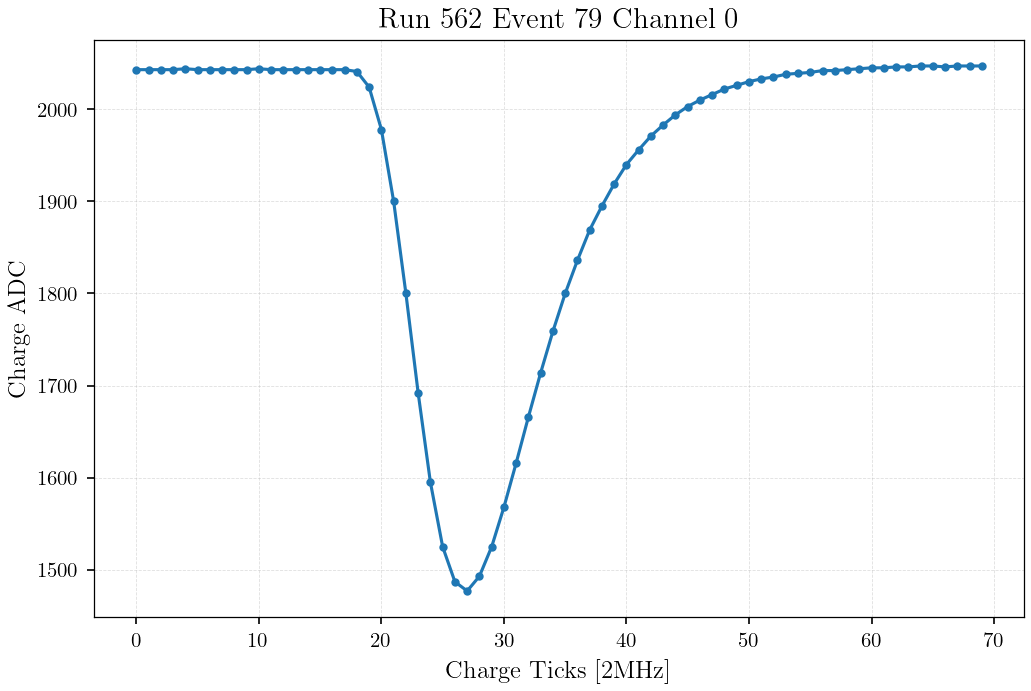

In [5]:
plt.plot(ribbon_df['charge_adc_words'][79][0,240:310], marker='.')
plt.xlabel('Charge Ticks [2MHz]')
plt.ylabel('Charge ADC')
plt.title('Run 562 Event 79 Channel 0')

In [6]:
light_samples_list = []
light_roi_list = []
charge_samples_list = []
charge_channels_list = []
for law,caw in zip(ribbon_df['light_adc_words'],ribbon_df['charge_adc_words']):
    if len(caw) > 0:
        charge_channels_list.append(caw.shape[0])
        charge_samples_list.append(caw.shape[1])
    else:
        charge_channels_list.append(0)
    if len(law) > 0:
        light_samples_list.append(law.shape[1])
        light_roi_list.append(law.shape[0])
    else:
        light_roi_list.append(0)
    

table = PrettyTable()
table.field_names = ["Charge", "Values", "Count"]

types,cnt = np.unique(charge_channels_list, return_counts=True)
table.add_row(["Channels per Event", types, cnt])

types,cnt = np.unique(charge_samples_list, return_counts=True)
table.add_row(["Words per Channel", types, cnt])
print(table)

table = PrettyTable()
table.field_names = ["Light", "Values", "Count"]

types,cnt = np.unique(light_roi_list, return_counts=True)
table.add_row(["ROIs per Event", types, cnt])

types,cnt = np.unique(light_samples_list, return_counts=True)
table.add_row(["Words per Channel", types, cnt])

types,cnt = np.unique(np.concatenate(ribbon_df['light_channel'].values), return_counts=True)
table.add_row(["Channels", types, cnt])

types,cnt = np.unique(np.concatenate(ribbon_df['light_trigger_id'].values), return_counts=True)
table.add_row(["Disc ID", types, cnt])

print(table)

+--------------------+---------+-------------+
|       Charge       |  Values |    Count    |
+--------------------+---------+-------------+
| Channels per Event | [ 0 64] | [   4 4996] |
| Words per Channel  |  [763]  |    [4996]   |
+--------------------+---------+-------------+
+-------------------+--------+--------+
|       Light       | Values | Count  |
+-------------------+--------+--------+
|   ROIs per Event  |  [0]   | [5000] |
| Words per Channel |   []   |   []   |
|      Channels     |   []   |   []   |
|      Disc ID      |   []   |   []   |
+-------------------+--------+--------+


## Preview Events

In [7]:
# modifying are_hits to also find negative pulses and the large dropout events 
def are_hits(readout_df, event):
    """
    Use for event selection. Check if there are any large-ish charge hits in the event in any of the 32 channels.
    """
    charge_channels = readout_df['charge_adc_words'] if event is None else readout_df['charge_adc_words'][event]
    for i in range(0, 32):
        if len(find_peaks(charge_channels[i,:], height=10, prominence=8)[0]) > 0 or len(find_peaks(-charge_channels[i,:], height=10, prominence=8)[0]) > 0:
            return True 
        if np.any(charge_channels[i,:] < 100):
            return True
    return False

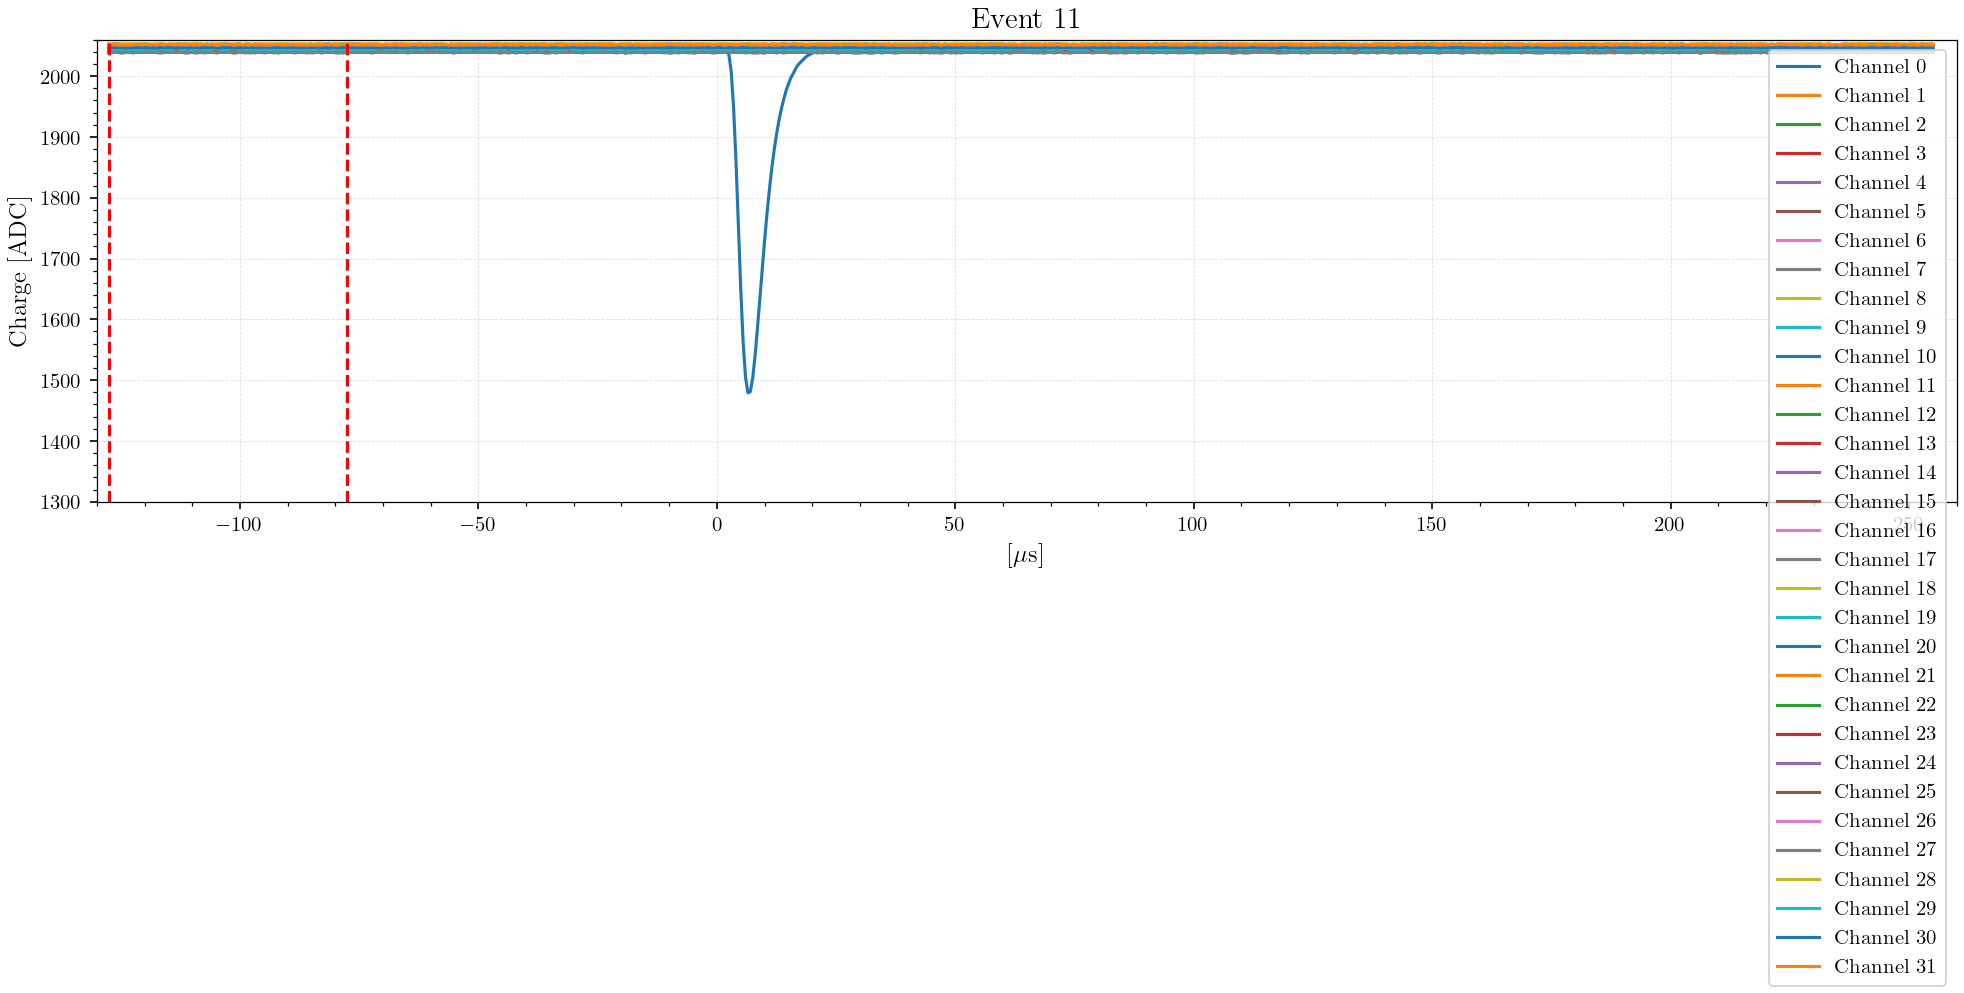

In [9]:
"""
Plotting of both the charge and light signals.
"""
light_channel = 0
channel_range = [0,31]
select_hit_events = True

for event in range(10,12):
    if ribbon_df['charge_adc_words'][event].ndim < 2:
        continue
    if not are_hits(readout_df=ribbon_df, event=event) and select_hit_events:
        continue

    # modified to EXCLUDE events that have hits (including baseline drop out)
    # if are_hits(ribbon_df=ribbon_df, event=event) and select_hit_events:
        # continue
    # Get the full 4 light frames from the event
    # full_axis, full_waveform = get_full_light_data(ribbon_df=ribbon_df, event=event, channel=light_channel)

    fig, ax1 = plt.subplots(figsize=(16,4))
    plot_charge_waveforms(readout_df=ribbon_df, event=event, channel_range=channel_range, timesize=255, overlay=True, range=[1300, 2060], create_fig=False, show_legend=True)
    
    # ax1.set_ylim(2043, 2051)

    # ax2 = ax1.twinx()
    # ax2.plot(full_axis/1e3, full_waveform-0, color='red', linestyle='--')
    # ax2.set_ylim(2000, 2500)
    # ax2.set_ylabel('Light [ADC]')
    
    plt.xlabel("[$\\mu$s]")
    plt.axvline(-127.5, color='red', linestyle='--')
    plt.axvline(-77.5, color='red', linestyle='--')
    plt.xlim(-130,260)
    plt.minorticks_on()
    plt.show()

## Calculate Baselines

In [45]:
channel_range = [0,32]
select_hit_events = True

ribbon_counts = {ch: [] for ch in range(channel_range[0], channel_range[1])}
# print(ribbon_counts)
for event in range(0,1000):
    if ribbon_df['charge_adc_words'][event].ndim < 2:
        continue
    # modified to EXCLUDE events that have hits (including drop out events)
    if not are_hits(readout_df=ribbon_df, event=event) and select_hit_events:
        continue

    charge_channels = ribbon_df['charge_adc_words'] if event is None else ribbon_df['charge_adc_words'][event]
    if np.any(charge_channels[0,:] < 100):
        continue

    for ch in np.arange(channel_range[0],channel_range[1]):
        ribbon_counts[ch].append(ribbon_df['charge_adc_words'][event][ch,0:20])

# print(ribbon_counts)

In [46]:
channel_range = [0,32]
select_hit_events = True

shield_counts = {ch: [] for ch in range(channel_range[0], channel_range[1])}
# print(shield_counts)
for event in range(0,1000):
    if ribbon_df['charge_adc_words'][event].ndim < 2:
        continue
    # modified to EXCLUDE events that have hits (including drop out events)
    if not are_hits(readout_df=shield_df, event=event) and select_hit_events:
        continue

    charge_channels = shield_df['charge_adc_words'] if event is None else shield_df['charge_adc_words'][event]
    if np.any(charge_channels[0,:] < 100):
        continue

    for ch in np.arange(channel_range[0],channel_range[1]):
        shield_counts[ch].append(shield_df['charge_adc_words'][event][ch,0:20])

# print(shield_counts)

In [47]:
def noise_hist(counts, channels=np.arange(0,30), baseline_guess=2048, range=20, num_bins=40, subplot=10, saveas=''):
    # based on input range and desired num_bins, create bins
    bins = np.linspace(baseline_guess - (range/2), baseline_guess + (range/2), num_bins)
    baselines = {} 
    rms = {}

    # if there is only one input channel, automatically turn off subplot
    if len(channels)==1: subplot=0

    # if subplot is enabled, find number of rows necessary and initialize plot
    if subplot:
        rows = len(channels) // subplot + (len(channels) % subplot > 0)
        if len(channels)>=subplot: 
            _, axs = plt.subplots(rows, subplot, figsize=(20, 2*rows))
        else: 
            _, axs = plt.subplots(rows, len(channels), figsize=(20, 2*len(channels)))
        
    for i, ch in enumerate(channels):
        if subplot:
            row = i//subplot # row index
            col = i%subplot # column index
            ax = axs[row, col]
        else:
            plt.figure(figsize=(4, 4))
            ax = plt.gca()
        
        all_counts = np.concatenate(counts[ch])
        
        # compute mean and std based on raw data
        mean = np.mean(all_counts)
        std = np.std(all_counts)

        # create histogram for current channel, find bin midpoints
        hist, bin_edges = np.histogram(all_counts, bins=bins, density=True)
        midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # fit gaussian to midpoints, initial guess based on mean and std of counts
        params, _ = curve_fit(gaussian, midpoints, hist, [np.mean(all_counts), np.std(all_counts)])
        mean_fit, std_fit = params
        
        # trust the fitted result more, so we return this in the dictionary
        baselines[ch] = (mean_fit)
        rms[ch] = std_fit

        # plot histogram
        ax.hist(all_counts, bins=bins, histtype='step', color=colors[0], density=True)
        
        # plot fitted gaussian
        x = np.linspace(min(bins), max(bins), range)
        fit = gaussian(x, mean, std)
        ax.fill_between(x, 0, fit, color=colors[9], alpha=0.5, label='Gaussian Fit')

        # plot expected and actual baseline positions
        ax.axvline(2048, color='r', ls='--', alpha=0.5, label='Expected BL')   
        ax.axvline(mean, color='r', ls='--', label='Actual BL')

        # title and legend
        ax.set_title(f'Ch. {ch}')

        ax.text(
            0.98, 0.95,
            r"$\bf{Raw:}$" + f"\nBL={mean:.1f}\nRMS={std:.1f}\n"
            r"$\bf{Gaussian:}$" + f"\nBL={mean_fit:.1f}\nRMS={std_fit:.1f}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )


        # ax.legend()

    plt.tight_layout()
    if saveas: plt.savefig(f'{savedir}/BaselineCountsRun{file_list}.{saveas}', dpi=400, bbox_inches='tight') # save plot

    # tabulate and display results
    results = {
        "Ch": list(baselines.keys()),
        "Mean Counts": list(baselines.values()),
        "RMS Counts": list(rms.values())
    }
    results_df = pd.DataFrame(results)
    display(results_df)
        
    return baselines, rms

,Ch,Mean Counts,RMS Counts
0,0,2042.975947,1.086005
1,1,2046.486187,0.491934
2,2,2048.258076,0.320032
3,3,2039.395135,0.491459
4,4,2046.249499,0.421550
5,5,2046.529424,0.489146
6,6,2045.293614,0.451641
7,7,2047.242177,0.395805
8,8,2045.086019,0.423818
9,9,2039.166530,0.343996


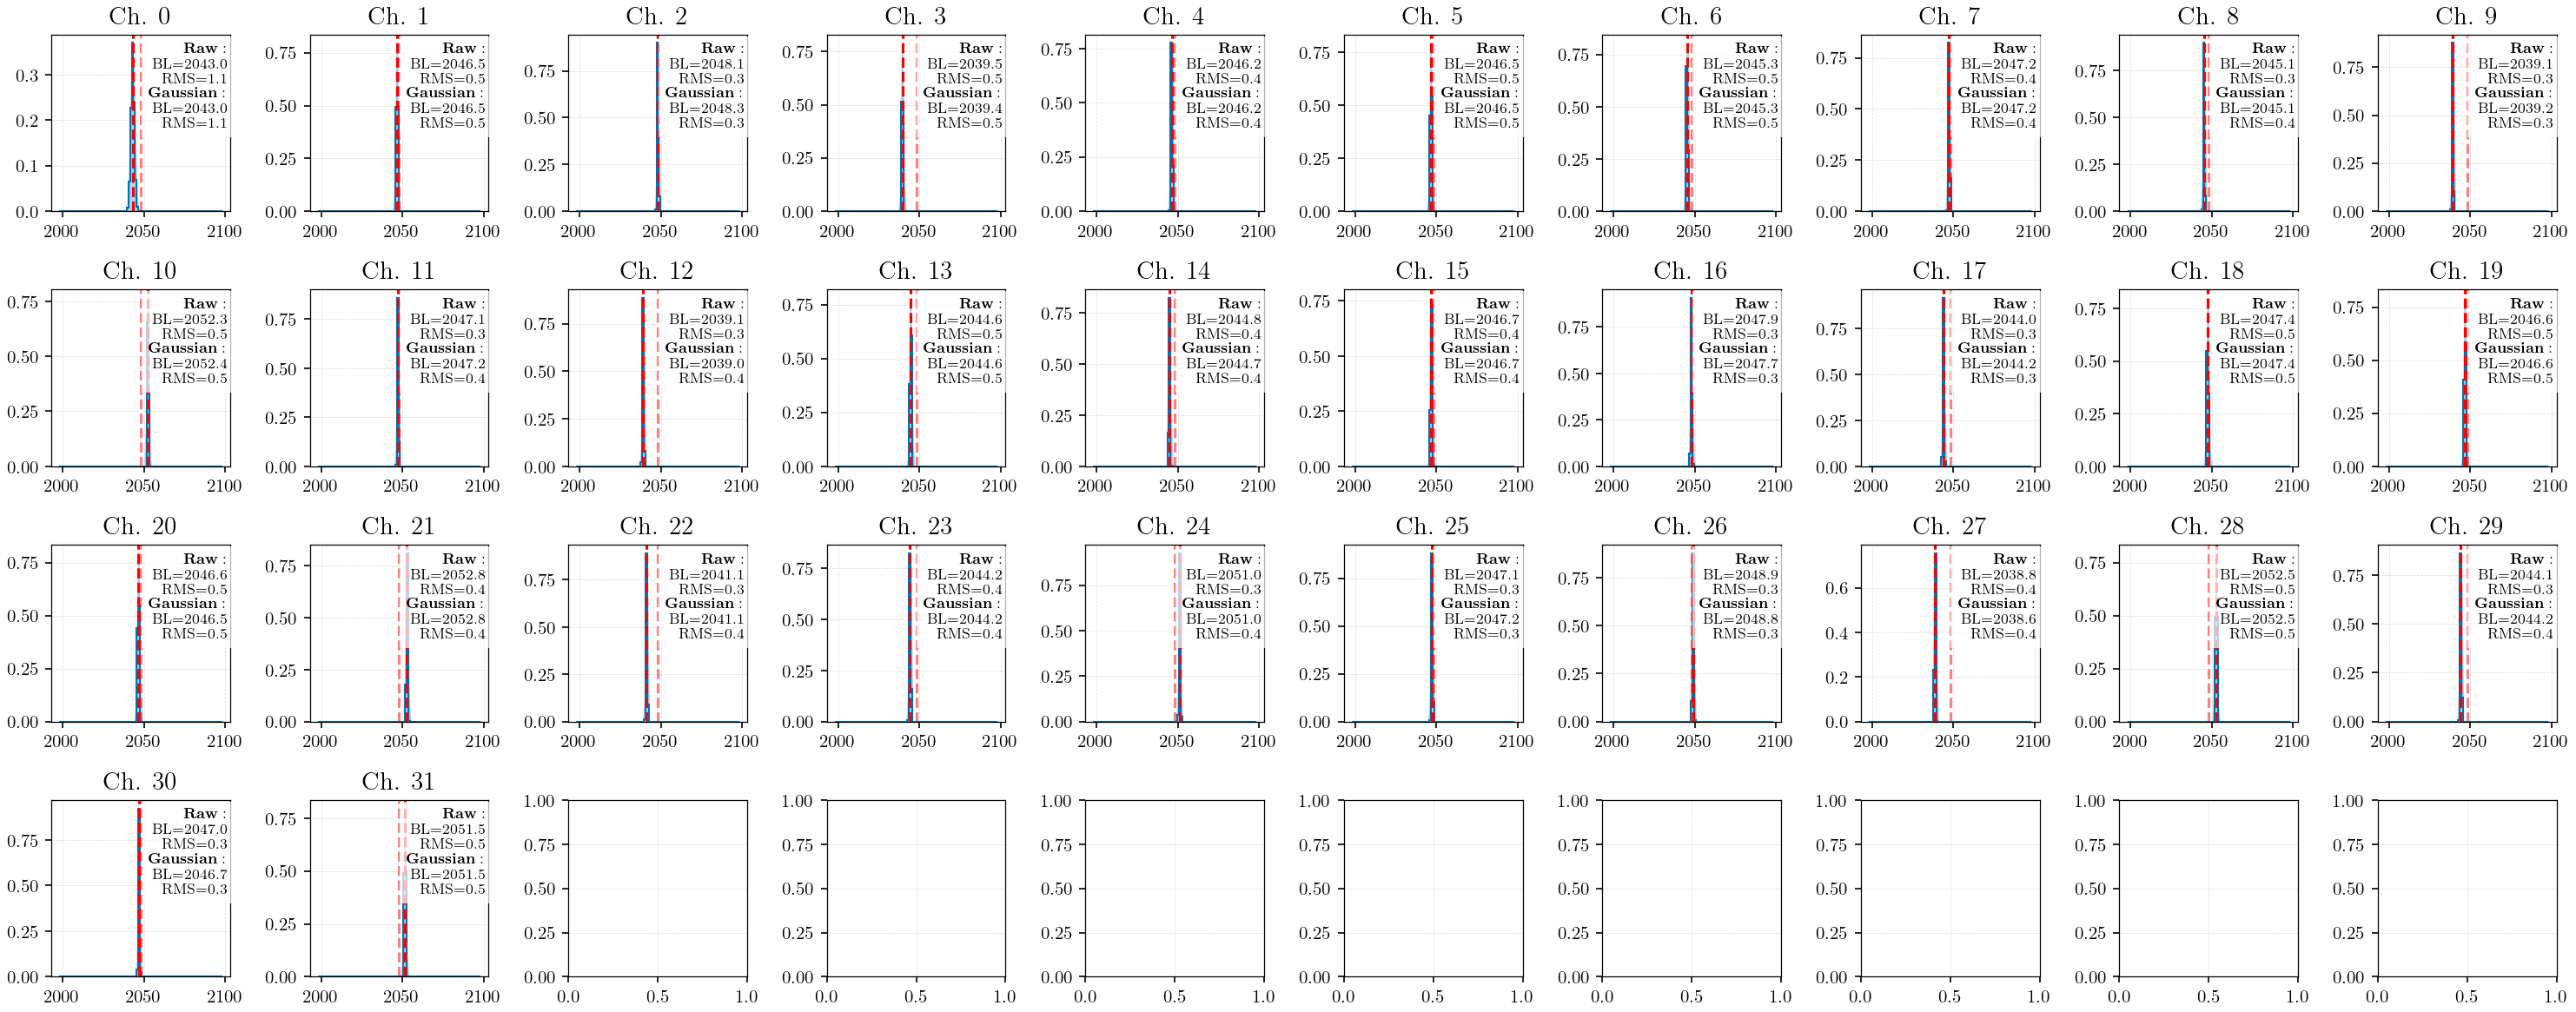

In [48]:
ribbon_baselines, ribbon_rms= noise_hist(ribbon_counts, channels=np.arange(0,32), range=100, num_bins=100)

,Ch,Mean Counts,RMS Counts
0,0,2042.976665,1.081819
1,1,2046.501722,0.491723
2,2,2048.259386,0.297596
3,3,2039.347039,0.486268
4,4,2046.239567,0.412404
5,5,2046.564595,0.483553
6,6,2045.325033,0.463801
7,7,2047.242122,0.394402
8,8,2045.144129,0.414148
9,9,2039.166660,0.341514


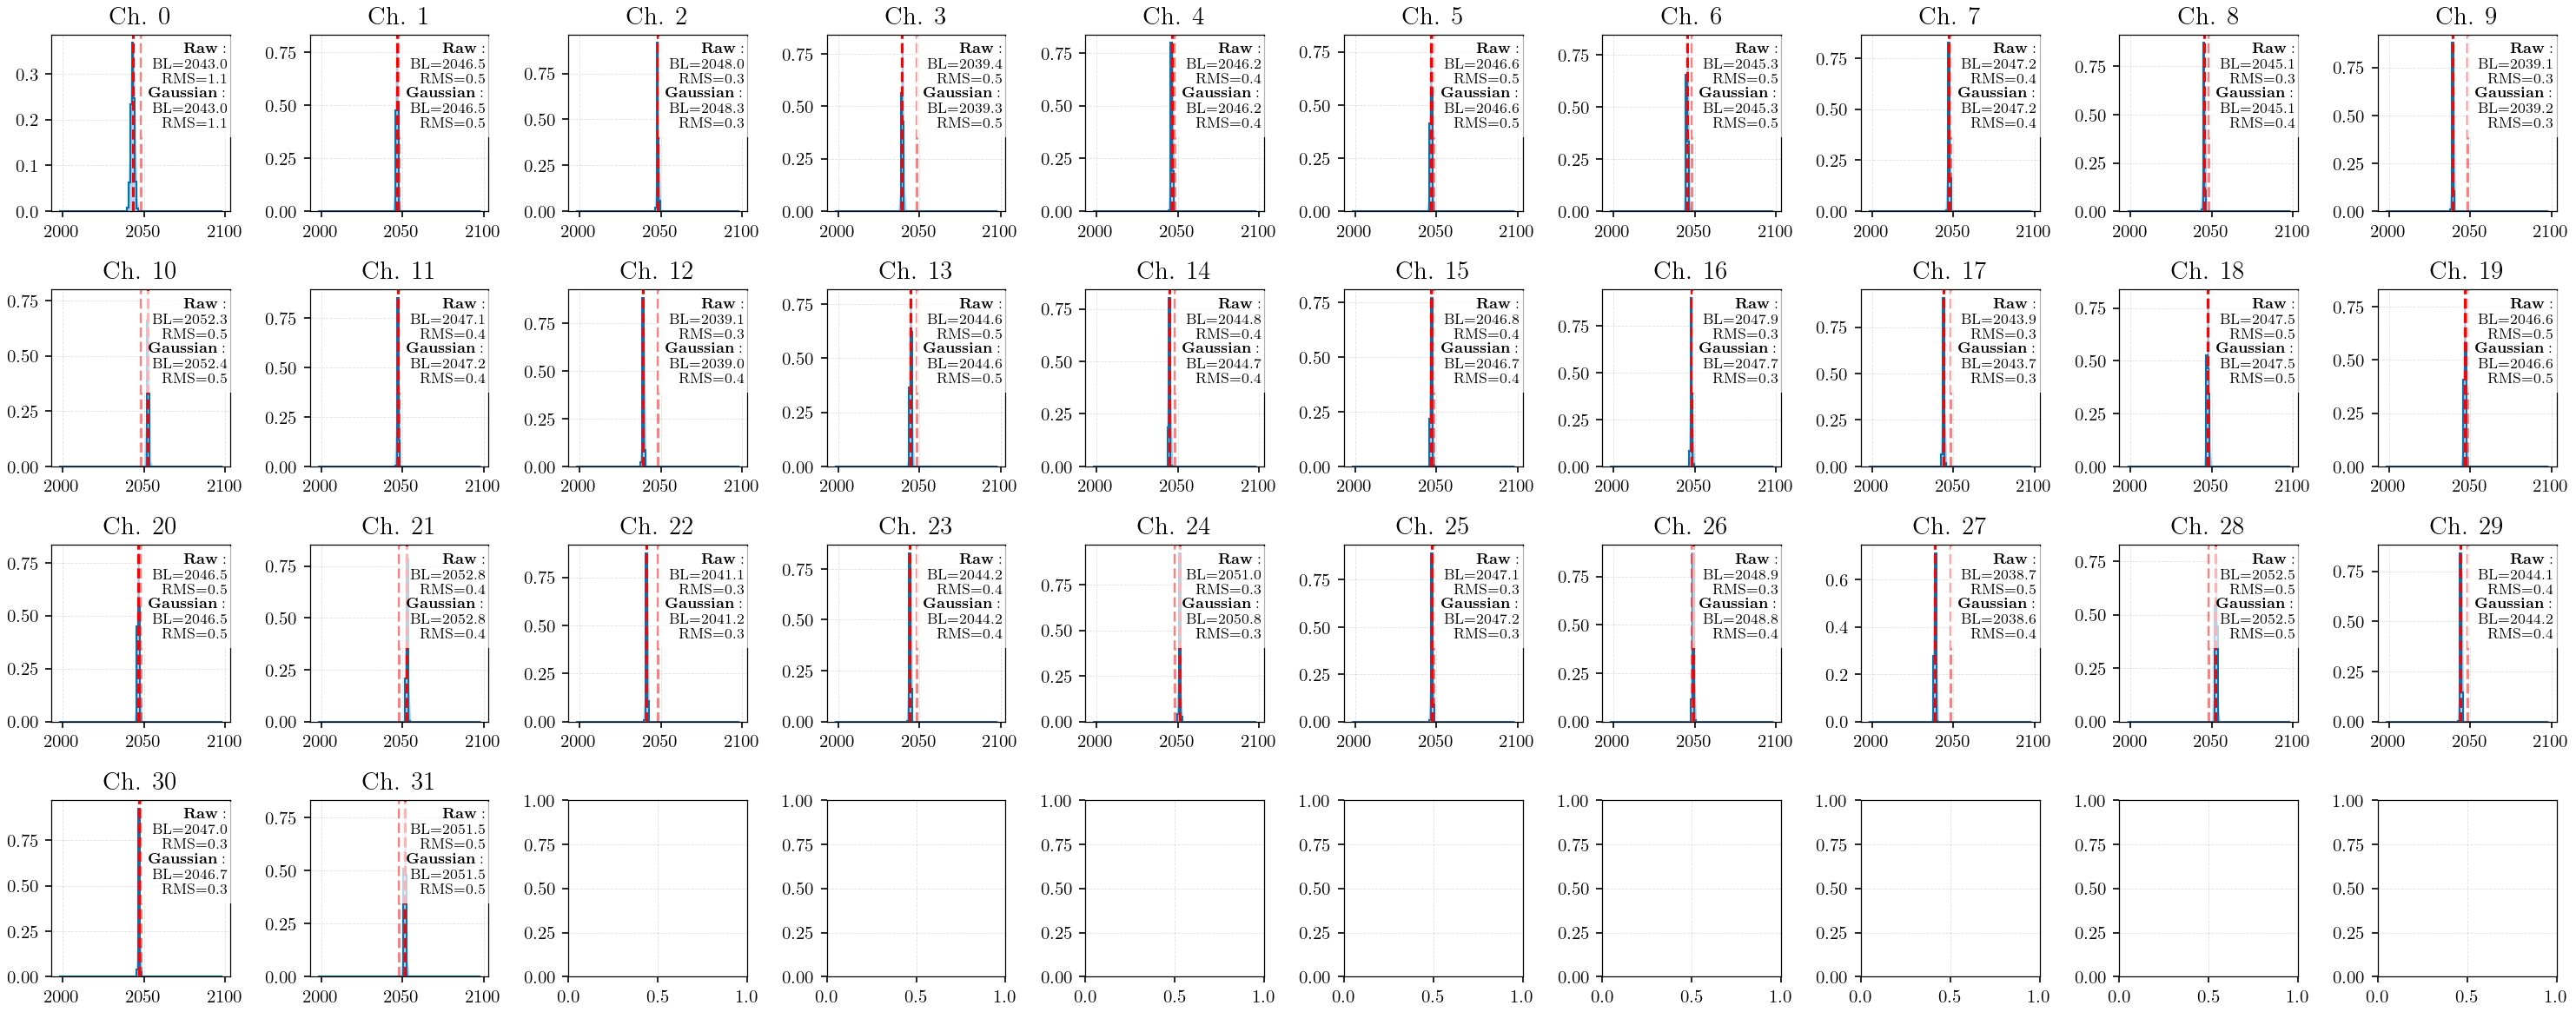

In [49]:
shield_baselines, shield_rms= noise_hist(shield_counts, channels=np.arange(0,32), range=100, num_bins=100)

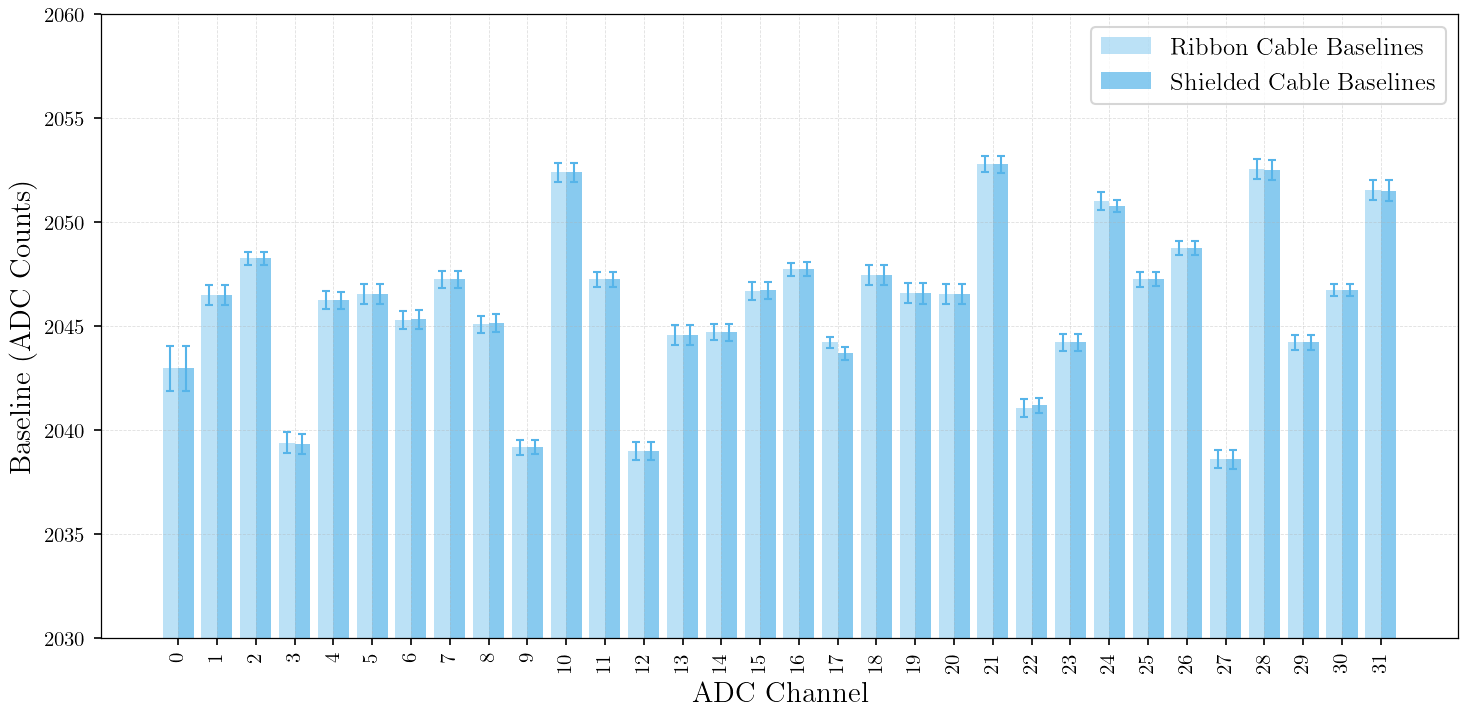

In [52]:
channels = list(ribbon_baselines.keys())

baseline = [ribbon_baselines[ch] for ch in channels]
baseline1 = [shield_baselines[ch] for ch in channels]
noise_rms = [ribbon_rms[ch] for ch in channels]
noise_rms1 = [shield_rms[ch] for ch in channels]
# neu_channels = ['T15','B15','T14','B14','T13','B13','T12','B12','T11','B11','T10','B10','T9','B9','T8','B8','T7','B7','T6','B6','T5','B5','T4','B4','T3','B3','T2','B2','T1','B1']

bar_width = 0.4
x = np.arange(len(channels))

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the first bar set, shifted left
bars1 = ax.bar(x - bar_width/2, baseline, width=bar_width, color=colors[9], alpha=0.4, label='Ribbon Cable Baselines',
yerr=noise_rms, capsize=2, error_kw=dict(ecolor=colors[9], elinewidth=1, capthick=1))
# Plot the second bar set, shifted right
bars2 = ax.bar(x + bar_width/2, baseline1, width=bar_width, color=colors[9], alpha=0.7, label='Shielded Cable Baselines',
yerr=noise_rms1, capsize=2, error_kw=dict(ecolor=colors[9], elinewidth=1, capthick=1))

ax.set_xlabel('ADC Channel', fontsize=14)
ax.set_ylabel('Baseline (ADC Counts)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([str(ch) for ch in channels], rotation=90, fontsize=10)

# Add legend
ax.legend(fontsize=12)

# Add secondary x-axis
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(x)
# ax2.set_xticklabels([str(ch) for ch in neu_channels], rotation=90, fontsize=10)
# ax2.set_xlabel('NEU TPC Channel', fontsize=14)

plt.ylim(2030, 2060)
plt.tight_layout()
plt.show()


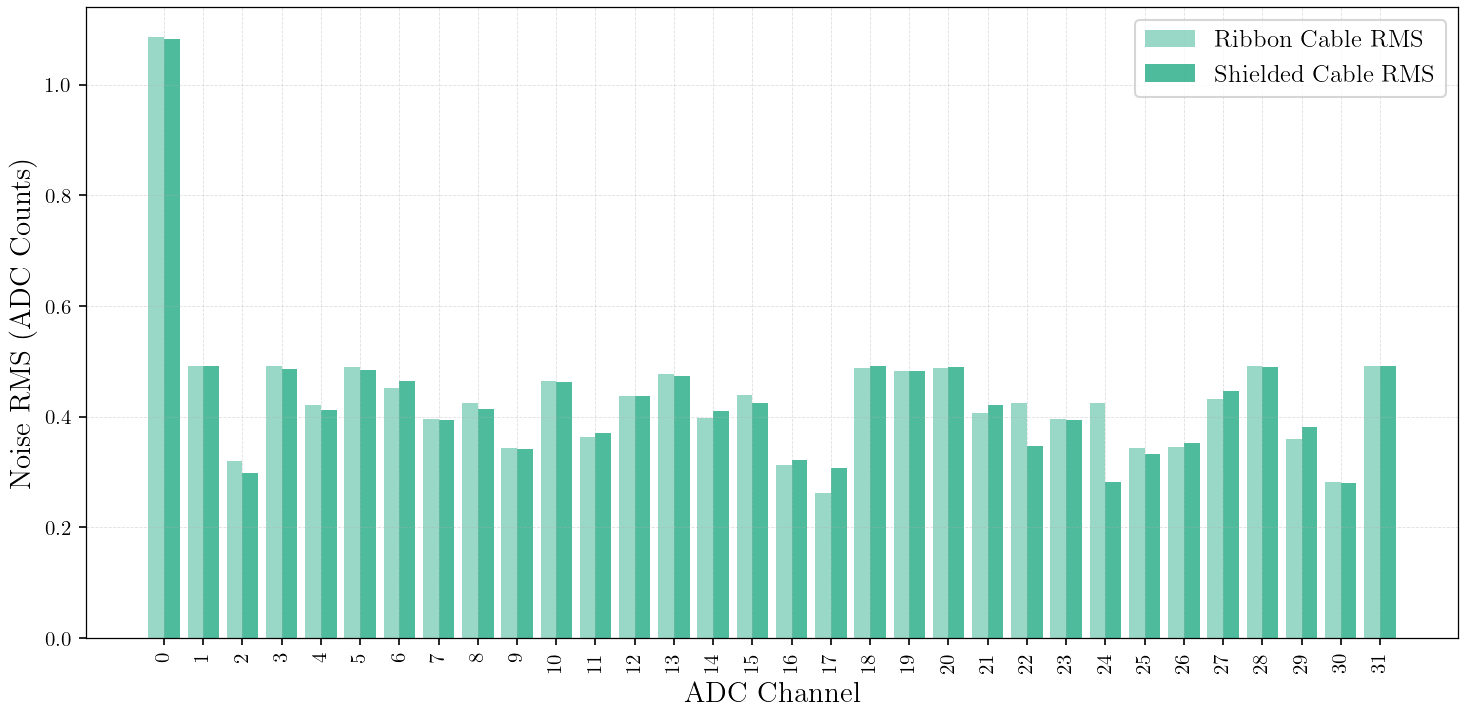

In [53]:
channels = list(ribbon_baselines.keys())

bar_width = 0.4
x = np.arange(len(channels))

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the first bar set, shifted left
bars1 = ax.bar(x - bar_width/2, noise_rms, width=bar_width, color=colors[2], alpha=0.4, label='Ribbon Cable RMS')
# Plot the second bar set, shifted right
bars2 = ax.bar(x + bar_width/2, noise_rms1, width=bar_width, color=colors[2], alpha=0.7, label='Shielded Cable RMS')

ax.set_xlabel('ADC Channel', fontsize=14)
ax.set_ylabel('Noise RMS (ADC Counts)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([str(ch) for ch in channels], rotation=90, fontsize=10)

# Add legend
ax.legend(fontsize=12)

# Add secondary x-axis
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(x)
# ax2.set_xticklabels([str(ch) for ch in neu_channels], rotation=90, fontsize=10)
# ax2.set_xlabel('NEU TPC Channel', fontsize=14)

plt.tight_layout()
plt.show()
